# Selection Task

## Restructuring for One-vs-Rest

The "animals" directory contains 90 different labels and each folder contains 60 images of each animal

For One-vs-Rest classification, we'll choose bat as our positive sample

The following code creates the appropriate directory structure, if it does not exist.

This notebook must be present in the same directory as the "animal" directory for the code to work.

Selecting 5 random images from each class to build the "others" label.

In [86]:
import os
import shutil
import random
src_folder = "animals/bat"
folders = os.listdir("animals")
temp = []
for folder in folders:
    if folder != "bat":
        temp.append([os.path.join("animals/"+folder, file) for file in random.sample(os.listdir("animals/"+folder),1)])
to_copy=[]
for temp_list in temp:
    for item in temp_list:
        to_copy.append(item)
if not os.path.exists("one-vs-rest"):
    shutil.copytree(src_folder, "one-vs-rest/bat")
    os.mkdir("one-vs-rest/others")
    for file_name in to_copy:
        shutil.copy2(file_name, "one-vs-rest/others/")

## Using existing architecture (ResNet) for binary classification (One vs Rest)

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [189]:
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [153]:
import pathlib
data_dir = pathlib.Path("one-vs-rest")

img_height,img_width=150,150
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 238 files belonging to 2 classes.
Using 191 files for training.
Found 238 files belonging to 2 classes.
Using 47 files for validation.


In [154]:
class_names = train_ds.class_names
print(class_names)

['bat', 'others']


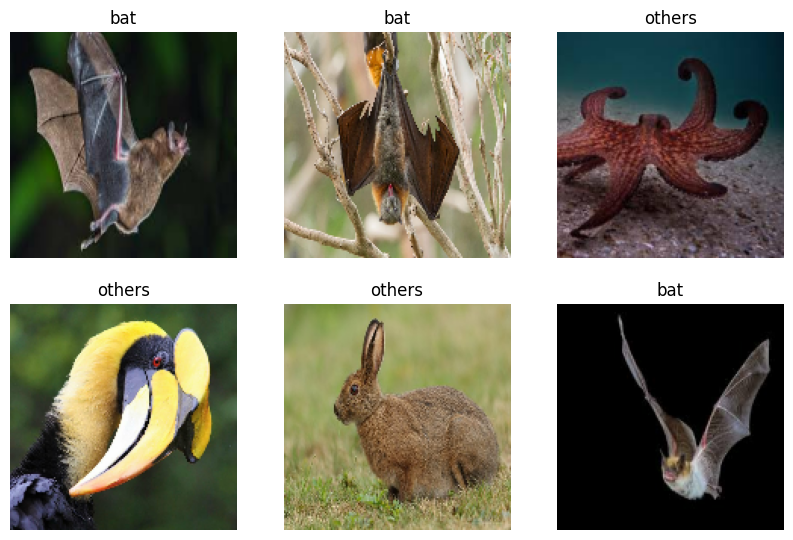

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [156]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(150,150,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [157]:
resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_18 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_19 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_20 (ModuleWr  (None, 1)                513       
 apper)                                                          
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
__________________________________

In [158]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [159]:
train_images = np.concatenate([images.numpy() for images, labels in train_ds])
train_labels = np.concatenate([labels.numpy() for images, labels in train_ds])
val_images = np.concatenate([images.numpy() for images, labels in val_ds])
val_labels = np.concatenate([labels.numpy() for images, labels in val_ds])

In [160]:
# Perform k-fold cross-validation
cv_scores = []
for train_idx, val_idx in kfold.split(train_images, train_labels):
    fold_train_data, fold_train_labels = train_images[train_idx], train_labels[train_idx]
    fold_val_data, fold_val_labels = train_images[val_idx], train_labels[val_idx]
    epochs=5
    history = resnet_model.fit(
      train_ds,
      validation_data=(fold_val_data, fold_val_labels),
      epochs=epochs
    )
    scores = resnet_model.evaluate(val_images, val_labels, verbose=0)
    cv_scores.append(scores[1])

Epoch 1/5
6/6 [==============================] - 4s 243ms/step - loss: 1.6680 - accuracy: 0.7173 - val_loss: 2.3097 - val_accuracy: 0.5312
Epoch 2/5
6/6 [==============================] - 1s 81ms/step - loss: 0.4118 - accuracy: 0.8639 - val_loss: 3.1068 - val_accuracy: 0.6719
Epoch 3/5
6/6 [==============================] - 1s 82ms/step - loss: 0.1649 - accuracy: 0.9162 - val_loss: 2.7307 - val_accuracy: 0.6094
Epoch 4/5
6/6 [==============================] - 1s 83ms/step - loss: 0.1064 - accuracy: 0.9372 - val_loss: 2.8133 - val_accuracy: 0.6094
Epoch 5/5
6/6 [==============================] - 1s 82ms/step - loss: 0.0345 - accuracy: 0.9948 - val_loss: 3.6178 - val_accuracy: 0.5938
Epoch 1/5
6/6 [==============================] - 1s 88ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 2.6386 - val_accuracy: 0.6875
Epoch 2/5
6/6 [==============================] - 1s 83ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 2.8250 - val_accuracy: 0.6875
Epoch 3/5
6/6 [==================

In [161]:
print("Average Accuracy:", np.mean(cv_scores))

Average Accuracy: 0.7872340679168701


In [200]:
#vgg = VGG16(input_shape=[img_height,img_width] + [3], weights='imagenet', include_top=False)
model = VGG16(weights = "imagenet", include_top=False, input_shape=(img_height,img_width,3))
#model.add(layers.Flatten(input_shape=(img_height,img_width,3)))

for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with custom head
#model = Model(inputs=base_model.input, outputs=predictions)
model_final = Model(inputs = model.input, outputs = predictions)
model_final.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=["accuracy"])

'''
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(train_ds), activation='sigmoid')(x)
vgg.add(Dense(1, activation='sigmoid'))
model = Model(inputs=vgg.input, outputs=prediction)
'''
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
r = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
)
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "C:\Users\suvid\.conda\envs\intern\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\suvid\.conda\envs\intern\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\suvid\.conda\envs\intern\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\suvid\.conda\envs\intern\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\suvid\.conda\envs\intern\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\suvid\AppData\Local\Temp\ipykernel_5704\818594915.py", line 31, in <module>
      r = model.fit(
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\metrics\base_metric.py", line 700, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\metrics\metrics.py", line 3669, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "C:\Users\suvid\.conda\envs\intern\lib\site-packages\keras\utils\metrics_utils.py", line 970, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_174019]

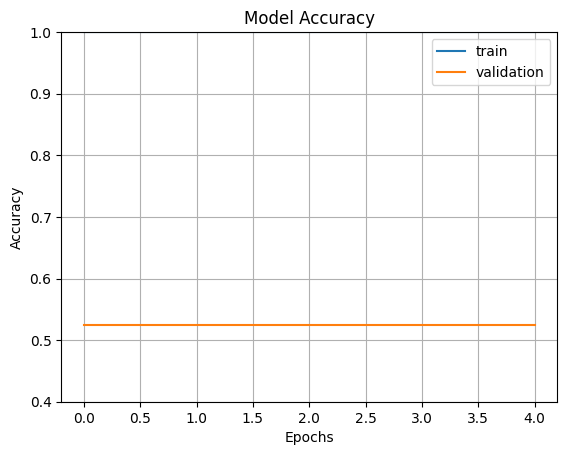

In [162]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

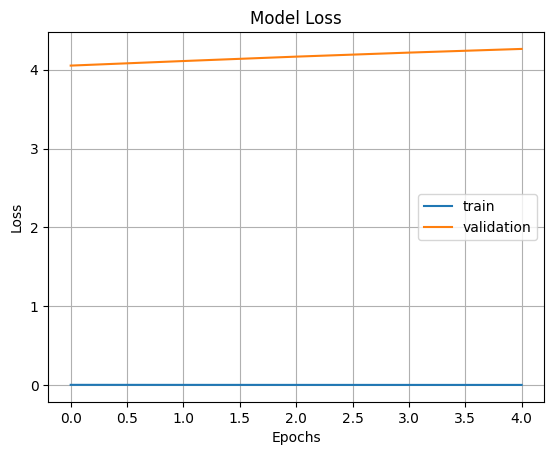

In [163]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


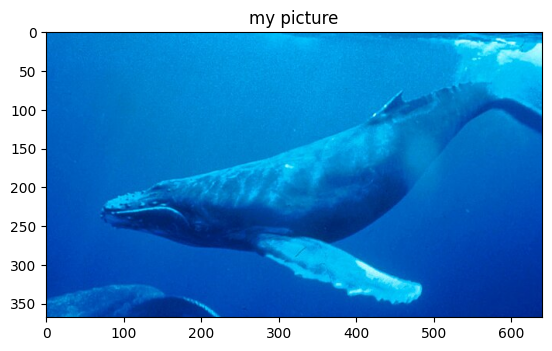

(1, 150, 150, 3)


In [167]:
import cv2
image=cv2.imread("C:\\Users\\suvid\\Desktop\\whale.jpg")
image_resized= cv2.resize(image, (img_height,img_width))

RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.title('my picture')
plt.show()
image=np.expand_dims(image_resized,axis=0)

print(image.shape)

In [168]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 22ms/step
[[0.99999213]]


In [169]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is bat


In [149]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root='one-vs-rest/', transform=transform)

# Define k-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

accuracies=[]

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    # Split dataset into train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Load pre-trained AlexNet model
    model = torchvision.models.alexnet(pretrained=True)

    # Freeze the parameters of the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer for binary classification
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)  # Binary classification, so 2 output classes

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(5):  # Number of epochs
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{5}, Training Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), f'alexnet_ovr_fold_{fold+1}.pth')

print("\nFinal Mean Accuracy:", '{0:.4f}'.format(np.mean(accuracies)))

Fold 1


C:\Users\suvid\.conda\envs\intern\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\suvid\.conda\envs\intern\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Training Loss: 0.4932
Epoch 2/5, Training Loss: 0.1409
Epoch 3/5, Training Loss: 0.0635
Epoch 4/5, Training Loss: 0.0384
Epoch 5/5, Training Loss: 0.0199
Validation Accuracy: 0.9625
Fold 2
Epoch 1/5, Training Loss: 0.5235
Epoch 2/5, Training Loss: 0.1369
Epoch 3/5, Training Loss: 0.0816
Epoch 4/5, Training Loss: 0.0291
Epoch 5/5, Training Loss: 0.0238
Validation Accuracy: 0.8861
Fold 3
Epoch 1/5, Training Loss: 0.6815
Epoch 2/5, Training Loss: 0.2231
Epoch 3/5, Training Loss: 0.1060
Epoch 4/5, Training Loss: 0.0705
Epoch 5/5, Training Loss: 0.0449
Validation Accuracy: 0.9620

Final Mean Accuracy: 0.9369


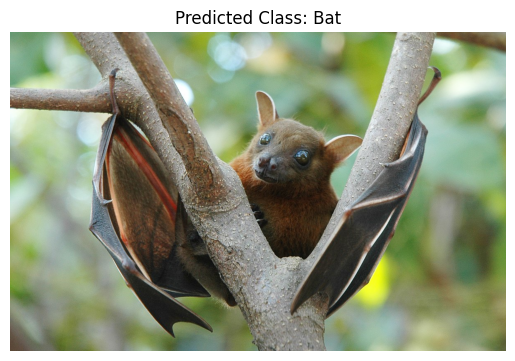

In [29]:
#Predicting

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = torchvision.models.alexnet(pretrained=True)  # Replace YourModelClass with the actual class of your model
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 2)  # Assuming binary classification (2 output classes)

# Load the saved state dictionary
state_dict = torch.load('alexnet_ovr_fold_1.pth')

# Remove the 'module.' prefix if present (for loading from a DataParallel model)
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Define transforms for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'C:\\Users\\suvid\\Desktop\\fruitbat.jpg'  # Replace with the path to your image
image = Image.open(image_path)
image = image.convert("RGB")

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Perform prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Get class label
class_labels = ['Bat', 'Others']  # Replace with your actual class labels
predicted_label = class_labels[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


## Restructuring for 5 Class Classification

We're taking 5 labels: cat, cow, octopus, oyster and panda

In [19]:
import os
import shutil
import random

if not os.path.exists("five-class"):
    shutil.copytree("animals/cat", "five-class/cat")
    shutil.copytree("animals/cow", "five-class/cow")
    shutil.copytree("animals/octopus", "five-class/octopus")
    shutil.copytree("animals/oyster", "five-class/oyster")
    shutil.copytree("animals/panda", "five-class/panda")


In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root='five-class/', transform=transform)

# Define k-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

accuracies=[]

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    # Split dataset into train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Load pre-trained AlexNet model
    model = torchvision.models.alexnet(pretrained=True)

    # Modify the final fully connected layer for 5-class classification
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)  # 5 output classes for 5-class classification

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Train the model
    for epoch in range(5):  # Number of epochs
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{5}, Training Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), f'alexnet_pretrained_5_class_fold_{fold+1}.pth')

print("\nFinal Mean Accuracy:", '{0:.4f}'.format(np.mean(accuracies)))

Fold 1
Epoch 1/5, Training Loss: 2.0340
Epoch 2/5, Training Loss: 1.5618
Epoch 3/5, Training Loss: 1.2037
Epoch 4/5, Training Loss: 0.9442
Epoch 5/5, Training Loss: 0.7466
Validation Accuracy: 0.8000
Fold 2
Epoch 1/5, Training Loss: 1.8057
Epoch 2/5, Training Loss: 1.3289
Epoch 3/5, Training Loss: 0.9609
Epoch 4/5, Training Loss: 0.7331
Epoch 5/5, Training Loss: 0.5253
Validation Accuracy: 0.8100
Fold 3
Epoch 1/5, Training Loss: 1.7709
Epoch 2/5, Training Loss: 1.3511
Epoch 3/5, Training Loss: 0.9841
Epoch 4/5, Training Loss: 0.7640
Epoch 5/5, Training Loss: 0.5536
Validation Accuracy: 0.7900

Final Mean Accuracy: 0.8000


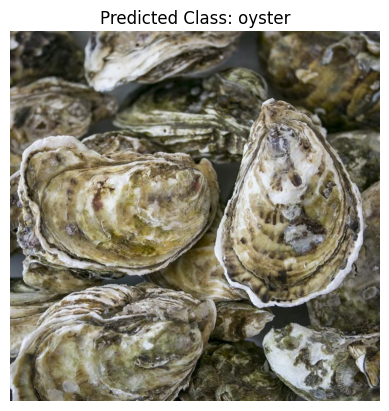

In [25]:
#Predicting

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = torchvision.models.alexnet(pretrained=True)  # Replace YourModelClass with the actual class of your model
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 5)  # Assuming binary classification (5 output classes)

# Load the saved state dictionary
state_dict = torch.load('alexnet_pretrained_5_class_fold_1.pth')

# Remove the 'module.' prefix if present (for loading from a DataParallel model)
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Define transforms for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'C:\\Users\\suvid\\Desktop\\oyster2.jpg'  # Replace with the path to your image
image = Image.open(image_path)
image = image.convert("RGB")

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Perform prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Get class label
class_labels = ["cat", "cow", "octopus", "oyster","panda"]  # Replace with your actual class labels
predicted_label = class_labels[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


# Custom Model Development

In [184]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)

### Data Augmentation

In [185]:
batch_size = 32
num_epochs = 20
learning_rate=0.0001

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

std_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the original dataset
original_dataset = datasets.ImageFolder('one-vs-rest/')

# Split dataset into train and test sets (for example, using random_split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset),len(test_dataset))
test_dataset.transform = std_transform
temp_train_dataset = train_dataset
train_dataset.transform = aug_transform
train_dataset = torch.utils.data.ConcatDataset([train_dataset, temp_train_dataset])
print(len(train_dataset),len(test_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

True
119 30
238 30


In [186]:
'''
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training, 20% for validation
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset),len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)'''

'\n# Split dataset into training and validation sets\ntrain_size = int(0.8 * len(dataset))  # 80% for training, 20% for validation\ntest_size = len(dataset) - train_size\ntrain_dataset, test_dataset = random_split(dataset, [train_size, test_size])\nprint(len(train_dataset),len(test_dataset))\n\ntrain_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])


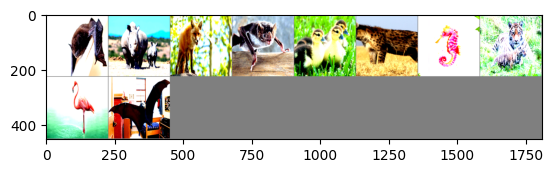

In [187]:
# show random images after loading the data

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [188]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Instantiate the model
model = ConvNet().to(device)


In [189]:
criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

'''
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))  # BCELoss expects a 2D tensor
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

print(f"Accuracy: {100 * correct / total}%")

#plt.plot(losses)
#plt.title('Training Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.show()
'''

kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs=10
accuracies = []
# Iterate through the splits
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    # Create DataLoader for current fold
    train_sampler = SubsetRandomSampler(train_index)
    test_sampler = SubsetRandomSampler(test_index)
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs,labels=inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Print training statistics
        print(f'Fold {fold+1}, Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader.dataset)}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs,labels=inputs.to(device),labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()

    print(f'Fold {fold+1}, Test Accuracy: {100 * correct / total}%')
    accuracies.append(correct / total)
print("Final accuracy:",np.mean(accuracies))

Fold 1, Epoch 1, Training Loss: 1.740241185130689
Fold 1, Epoch 2, Training Loss: 1.9505183068697884
Fold 1, Epoch 3, Training Loss: 1.5305403067461596
Fold 1, Epoch 4, Training Loss: 0.8410279945276627
Fold 1, Epoch 5, Training Loss: 0.6910024161306804
Fold 1, Epoch 6, Training Loss: 0.7331800128789556
Fold 1, Epoch 7, Training Loss: 0.390057269358795
Fold 1, Epoch 8, Training Loss: 0.37556384193817244
Fold 1, Epoch 9, Training Loss: 0.33574081427298935
Fold 1, Epoch 10, Training Loss: 0.447094269246863
Fold 1, Test Accuracy: 74.0%
Fold 2, Epoch 1, Training Loss: 0.9237846800144887
Fold 2, Epoch 2, Training Loss: 0.3640022025812392
Fold 2, Epoch 3, Training Loss: 0.36910501182479344
Fold 2, Epoch 4, Training Loss: 0.46506776905699865
Fold 2, Epoch 5, Training Loss: 0.39185032748535975
Fold 2, Epoch 6, Training Loss: 0.38029811196279206
Fold 2, Epoch 7, Training Loss: 0.38148071461875965
Fold 2, Epoch 8, Training Loss: 0.34946126425826307
Fold 2, Epoch 9, Training Loss: 0.2677056517376

Epoch [1/10], Loss: 22.2684
Epoch [2/10], Loss: 1.0175
Epoch [3/10], Loss: 0.6878
Epoch [4/10], Loss: 0.6564
Epoch [5/10], Loss: 0.7172
Epoch [6/10], Loss: 0.6827
Epoch [7/10], Loss: 0.6775
Epoch [8/10], Loss: 0.6624
Epoch [9/10], Loss: 0.6092
Epoch [10/10], Loss: 0.6571
Accuracy on test set: 0.7000


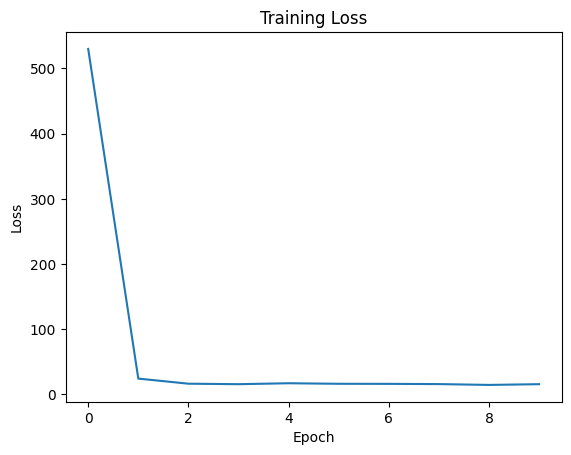

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split
import os

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset from directory
data_dir = 'one-vs-rest/'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AlexNet()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    losses.append(running_loss / 5)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.4f}")
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset from directory
data_dir = 'one-vs-rest/'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define the indices for 3-fold cross-validation
num_samples = len(dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
split1 = num_samples // 3
split2 = 2 * (num_samples // 3)
fold_indices = {
    0: indices[:split1],
    1: indices[split1:split2],
    2: indices[split2:]
}

# Define the model architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define training parameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

accuracies = []

# Define the cross-validation loop
for fold in range(3):
    print(f"Fold {fold + 1} / 3:")
    train_indices = [idx for idx in range(num_samples) if idx not in fold_indices[fold]]
    test_indices = fold_indices[fold]
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    # Initialize the model, loss function, and optimizer
    model = AlexNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_indices)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Accuracy on test set: {accuracy:.4f}")

print(f"Final Accuracy: {np.mean(accuracies):.4f}")

Fold 1 / 3:
Epoch [1/10], Loss: 5.6140
Epoch [2/10], Loss: 0.7254
Epoch [3/10], Loss: 0.6986
Epoch [4/10], Loss: 0.6647
Epoch [5/10], Loss: 0.6494
Epoch [6/10], Loss: 0.6159
Epoch [7/10], Loss: 0.5614
Epoch [8/10], Loss: 0.5685
Epoch [9/10], Loss: 0.5984
Epoch [10/10], Loss: 0.5590
Accuracy on test set: 0.6939
Fold 2 / 3:
Epoch [1/10], Loss: 2.2236
Epoch [2/10], Loss: 4.0143
Epoch [3/10], Loss: 0.6927
Epoch [4/10], Loss: 0.6937
Epoch [5/10], Loss: 0.6779
Epoch [6/10], Loss: 0.6741
Epoch [7/10], Loss: 0.6826
Epoch [8/10], Loss: 0.6332
Epoch [9/10], Loss: 0.6296
Epoch [10/10], Loss: 0.6128
Accuracy on test set: 0.7551
Fold 3 / 3:
Epoch [1/10], Loss: 7.0774
Epoch [2/10], Loss: 0.7509
Epoch [3/10], Loss: 0.6616
Epoch [4/10], Loss: 0.6784
Epoch [5/10], Loss: 0.6635
Epoch [6/10], Loss: 0.5734
Epoch [7/10], Loss: 0.6061
Epoch [8/10], Loss: 0.5531
Epoch [9/10], Loss: 0.5739
Epoch [10/10], Loss: 0.5431
Accuracy on test set: 0.7059
Final Accuracy: 0.7183


In [206]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset from directory
data_dir = 'one-vs-rest/'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define the indices for 3-fold cross-validation
num_samples = len(dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
split1 = num_samples // 3
split2 = 2 * (num_samples // 3)
fold_indices = {
    0: indices[:split1],
    1: indices[split1:split2],
    2: indices[split2:]
}

# Define the model architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define training parameters
learning_rate = 0.0001
num_epochs = 10
batch_size = 32

# Define the cross-validation loop
for fold in range(3):
    print(f"Fold {fold + 1} / 3:")
    train_indices = [idx for idx in range(num_samples) if idx not in fold_indices[fold]]
    test_indices = fold_indices[fold]
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    # Initialize the model, loss function, and optimizer
    model = AlexNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_indices)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Accuracy on test set: {accuracy:.4f}")

print(f"Final Accuracy: {np.mean(accuracies):.4f}")

Fold 1 / 3:
Epoch [1/10], Loss: 0.6807
Epoch [2/10], Loss: 0.6454
Epoch [3/10], Loss: 0.6377
Epoch [4/10], Loss: 0.5952
Epoch [5/10], Loss: 0.6607
Epoch [6/10], Loss: 0.5655
Epoch [7/10], Loss: 0.5527
Epoch [8/10], Loss: 0.5601
Epoch [9/10], Loss: 0.5309
Epoch [10/10], Loss: 0.5146
Accuracy on test set: 0.7347
Fold 2 / 3:
Epoch [1/10], Loss: 0.6867
Epoch [2/10], Loss: 0.7093
Epoch [3/10], Loss: 0.6614
Epoch [4/10], Loss: 0.6563
Epoch [5/10], Loss: 0.6030
Epoch [6/10], Loss: 0.6009
Epoch [7/10], Loss: 0.5542
Epoch [8/10], Loss: 0.5801
Epoch [9/10], Loss: 0.5640
Epoch [10/10], Loss: 0.5486
Accuracy on test set: 0.7143
Fold 3 / 3:
Epoch [1/10], Loss: 0.6746
Epoch [2/10], Loss: 0.7271
Epoch [3/10], Loss: 0.6336
Epoch [4/10], Loss: 0.6355
Epoch [5/10], Loss: 0.5858
Epoch [6/10], Loss: 0.5415
Epoch [7/10], Loss: 0.5329
Epoch [8/10], Loss: 0.6098
Epoch [9/10], Loss: 0.4994
Epoch [10/10], Loss: 0.4799
Accuracy on test set: 0.6471
Final Accuracy: 0.6913


In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load your dataset here (replace this with your own dataset loading code)
# Example: 
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# train_dataset = datasets.ImageFolder('train_folder', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define your dataset and dataloader
# Example:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the dataset from directory
data_dir = 'one-vs-rest/'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = AlexNet(num_classes=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))  # BCELoss expects a 2D tensor
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Epoch [1/12], Loss: 9.2842
Epoch [2/12], Loss: 0.7631
Epoch [3/12], Loss: 0.6887
Epoch [4/12], Loss: 0.7296
Epoch [5/12], Loss: 0.7297
Epoch [6/12], Loss: 0.6478
Epoch [7/12], Loss: 0.6252
Epoch [8/12], Loss: 0.6798
Epoch [9/12], Loss: 0.6736
Epoch [10/12], Loss: 0.6665
Epoch [11/12], Loss: 0.6562
Epoch [12/12], Loss: 0.6529
Accuracy: 60.0%
